<a href="https://colab.research.google.com/github/ulya1202/Computer_vision_projects/blob/main/Conglomerate_Concrete_Crack_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -q '/content/drive/MyDrive/Conglomerate Concrete Crack Detection.zip'

In [ ]:
import tensorflow as tf
import os




def load_image_mask(image_path, mask_path):
    #image-i emal#io-input output
    image=tf.io.read_file(image_path)#Verilmiş image_path ünvanındakı faylı oxuyur (binary formatda).
    image=tf.image.decode_jpeg(image, channels=3)#Amma bəzi JPEG fayllar grayscale (yəni tək kanal) və ya hətta CMYK (4 kanal) formatında da ola bilər (çox nadir hallarda).
    image=tf.image.resize(image, [256,256]) #?
    image=tf.cast(image, tf.float32)/255 #Daha dəqiq riyazi əməliyyatlar üçün istifadə olunur.

    #mask_file da
    mask=tf.io.read_file(mask_path)
    mask=tf.image.decode_png(mask, channels=1)#output daha deqiq oludn png , ve aq qar aona gore ccahnell 1
    mask=tf.image.resize(mask, [256,256]) # Changed (256,256) to [256,256] to ensure the correct input format
    mask=tf.cast(mask, tf.float32)/255

    return image,mask

In [ ]:
def augment(image, mask):
    if tf.random.uniform(())>0.5:#50 faiz boyuk
        image=tf.image.flip_left_right(image)#inputu soldan saqa cevirdimse
        mask=tf.image.flip_left_right(mask)#outputu cevirmelirem

    if tf.random.uniform(())>0.5:
        image=tf.image.flip_up_down(image)
        mask=tf.image.flip_up_down(mask)

    if tf.random.uniform(())>0.5:
        image=tf.image.random_brightness(image, max_delta=0.1) #parlaqlari inputu deyishdir , outputa ehtiyac yoxdu
    if tf.random.uniform(())>0.5:
        image=tf.image.random_contrast(image, lower=0.9, upper=1.1)

    return image, mask

In [ ]:
def create_dataset(image_paths, mask_paths, batch_size=16, augument_data=False):

    #sort eedirk, cutlukleri goturrsun deye
    image_paths=sorted([os.path.join(image_paths, fname) for fname in os.listdir(image_paths)])
    mask_paths=sorted([os.path.join(mask_paths, fname) for fname in os.listdir(mask_paths)])

    #input,output - tensor setleri shekilinde
    dataset=tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    #peprocess edir shekileri_________
    dataset=dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)# num_parallel_calls=tf.data.AUTOTUNE → TensorFlow avtomatik qərar verir neçə paralel nüvə ilə oxusun (sürət üçün).


    #preprocesse dir_________
    if augument_data:#eger trudursa augument eel bun on a gore el edirk , ki ,train zamni aug elesin amma test zamni elemsein
        dataset=dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)#qarushdursin??

    dataset=dataset.shuffle(buffer_size=1000) if augument_data else dataset

    dataset=dataset.batch(batch_size)
    dataset=dataset.prefetch(tf.data.AUTOTUNE)# num_parallel_calls=tf.data.AUTOTUNE → TensorFlow avtomatik qərar verir neçə paralel nüvə ilə oxusun (sürət üçün).

    return dataset

In [ ]:
train_dataset=create_dataset(image_paths='/content/Conglomerate Concrete Crack Detection/Train/images',
                             mask_paths='/content/Conglomerate Concrete Crack Detection/Train/masks',
                            batch_size=16,
                              augument_data=True)

In [ ]:
val_dataset=create_dataset(image_paths='/content/Conglomerate Concrete Crack Detection/Test/images',
                             mask_paths='/content/Conglomerate Concrete Crack Detection/Test/masks',
                           batch_size=16,
                           augument_data=False)

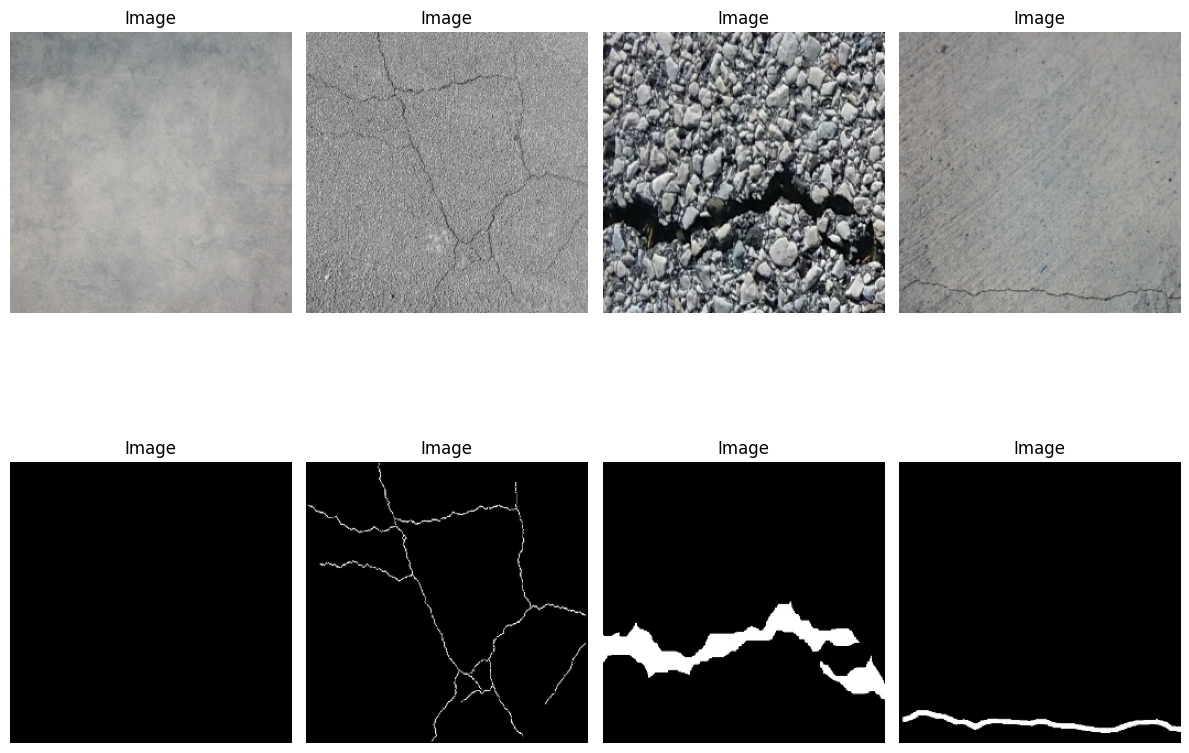

In [ ]:
import matplotlib.pyplot as plt
import random
#directorilerin adlarni secirek
image_dir='/content/Conglomerate Concrete Crack Detection/Train/images'
mask_dir='/content/Conglomerate Concrete Crack Detection/Train/masks'


#her iamgei directorilerden gotururk , pathlerin ve sort edirk
image_paths=sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths=sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])


#image_paths siyahısında 10 element varsa, bu hissə range(10) ilə [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
#İkinci parametr 4 olduğuna görə, range(len(image_paths)) içərisindən 4 təsadüfi unikal dəyər seçir.
idx=random.sample(range(len(image_paths)),4)

plt.figure(figsize=(12,10))

for i in range(len(idx)):
    #random secdiyi indexin 1-ci .. sira ile , ve iimge_pathsden
    img, msk=load_image_mask(image_paths[idx[i]], mask_paths[idx[i]])

    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(2,4,i+5)
    plt.imshow(msk, cmap='gray')
    plt.title('Image')
    plt.axis('off')

plt.tight_layout()

In [ ]:
def conv_block(inputs, num_filters):
    x=tf.keras.layers.Conv2D(num_filters,3, padding='same')(inputs)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Activation('leaky_relu')(x)
    x=tf.keras.layers.Dropout(rate=0.5)(x)

    x=tf.keras.layers.Conv2D(num_filters,3, padding='same')(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Activation('leaky_relu')(x) #overfititnge qarshi
    x=tf.keras.layers.Dropout(rate=0.5)(x) #

    return x

def encoder_block(inputs, num_filters):
    #evvelki conv layerlerimiz, neceh filter ile+MAx pool-->skiip uchun , ve daxile oturulmesin uchun
    x=conv_block(inputs, num_filters)#x- diger hisseye skip edeceyik
    p=tf.keras.layers.MaxPool2D((2,2))(x)
    return x,p

def decoder_block(inputs, skip_feature, num_filters):
    #yuxaridaki x ve skipler,    input--> evvelki layer +skip olan yeni yuxarida gelen.

    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = tf.keras.layers.Concatenate()([x, skip_feature])  # Concatenate layer applied here
    x = conv_block(x, num_filters) ###konvolution
    return x


def build_unet(input_shape):
    inputs=tf.keras.layers.Input(shape=input_shape)

    s1,p1=encoder_block(inputs,32)## encoder-->conv_blocak-->
    s2,p2=encoder_block(p1,64)
    s3,p3=encoder_block(p2,128)
    s4,p4=encoder_block(p3,256)

    b1=conv_block(p4,512)

    d1=decoder_block(b1,s4,256)
    d2=decoder_block(d1,s3,128)
    d3=decoder_block(d2,s2,64)
    d4=decoder_block(d3,s1,32)

    output=tf.keras.layers.Conv2D(1,1, padding='same', activation='sigmoid')(d4)
    model=tf.keras.Model(inputs,output, name='U-net')
    return model

input_shape=(256,256,3)
model=build_unet(input_shape)

In [ ]:
# model.compile(optmizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.fit(train_dataset, epochs=5, validation_data=val_dataset)

In [ ]:
def dice_loss(y_true, y_pred, smooth=1):
    #y_true-nu cast elesein float kimi
    y_true=tf.cast(y_true, tf.float32)
    #y_pred de float kimi
    y_pred=tf.cast(y_pred, tf.float32)

    #Bu funksiya Tensor (məsələn, matris, vektor və s.) üzərində elementləri toplayır. İstəyə görə, bütün elementi, ya da müəyyən ox (axis) üzrə toplaya bilər.
    intersection = tf.reduce_sum(y_true * y_pred) #y_true ve y_pred i bir birilerine vurduqda eger sef predik edirs e 0 olu., ve sonra cemelyir neche pikseli duz tapib.

    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) #trularin cemi

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

def bce_dice_loss(y_true, y_pred):
    bce=tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice=dice_loss(y_true, y_pred)
    return bce+dice

def dice_coef(y_true, y_pred, smooth=1):
    y_true=tf.cast(y_true, tf.float32)
    y_pred=tf.cast(y_pred>0.5, tf.float32)

    intersection=tf.reduce_sum(y_true*y_pred)

    union=tf.reduce_sum(y_true)+tf.reduce_sum(y_pred)

    dice=(2.*intersection+smooth)/(union+smooth)
    return dice
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=bce_dice_loss,
    metrics=[dice_coef]
)

model.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5
619/619 ━━━━━━━━━━━━━━━━━━━━ 335s 446ms/step - dice_coef: 0.2485 - loss: 1.3831 - val_dice_coef: 0.1305 - val_loss: 1.1743
Epoch 2/5
619/619 ━━━━━━━━━━━━━━━━━━━━ 225s 352ms/step - dice_coef: 0.3558 - loss: 1.0721 - val_dice_coef: 0.0570 - val_loss: 1.1032
Epoch 3/5
619/619 ━━━━━━━━━━━━━━━━━━━━ 222s 352ms/step - dice_coef: 0.4769 - loss: 0.9048 - val_dice_coef: 0.0731 - val_loss: 1.0743
Epoch 4/5
619/619 ━━━━━━━━━━━━━━━━━━━━ 227s 360ms/step - dice_coef: 0.5313 - loss: 0.7913 - val_dice_coef: 0.1232 - val_loss: 1.0431
Epoch 5/5
619/619 ━━━━━━━━━━━━━━━━━━━━ 225s 357ms/step - dice_coef: 0.5583 - loss: 0.7138 - val_dice_coef: 0.1870 - val_loss: 0.9902


In [ ]:
def visualize_overlay_samples(image_dir, mask_Dir, num_samples=5, alpha=0.8):
    image_paths=sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths=sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

    sample_indices=random.sample(range(len(image_paths)), num_samples)

    plt.figure(figsize=(8, num_samples*3))

    for i , idx in enumerate(sample_indices):
        img,msk=load_image_mask(image_paths[idx], mask_paths=[idx])

        img=img.numpy()
        msk=msk.numpy()

        msk_rgb=tf.concat([msk, msk, msk], axis=-1).numpy()

        overlay=img.copy()

        overlay[msk_rgb[:,:,0]>0.5]=[1.0,0,0]

        blended=(1-alpha)*img+alpha*overlay

        plt.subplot(num_samples, 1, i+1)
        plt.imshow(blended)
        plt.title(f'Image{idx} with Mask  Overlay')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def visualize_predictions(model, image_dir, mask_dir, num_samples=5, alpha=0.4):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

    sample_indices = random.sample(range(len(image_paths)), num_samples)

    plt.figure(figsize=(8, num_samples * 3))

    for i, idx in enumerate(sample_indices):
        # img, mask yukle
        img, msk = load_image_mask(image_paths[idx], mask_paths[idx])

        # predictonlar
        pred_mask = model.predict(tf.expand_dims(img, axis=0))[0]

        # mask ve img hazirla
        img = img.numpy()
        msk = msk.numpy()

        # mask to rgb
        msk_rgb = tf.concat([msk, msk, msk], axis=-1).numpy()  # 3 channel olmasini deqiqleshidr
        pred_rgb = tf.concat([pred_mask, pred_mask, pred_mask], axis=-1)  #rgb kimi predic

        # Overlay: Image + (Ground truth mask * color)
        gt_overlay = img.copy()
        # Change here: Assign to all 3 color channels
        gt_overlay[msk_rgb[:,:,0] > 0.5] = [1.0, 0, 0]  # Red color where mask is 1

        # Overlay: Image + (Predicted mask * color)
        pred_overlay = img.copy()

        pred_overlay[pred_rgb[:,:,0] > 0.5] = [0, 1.0, 0]  # yashil reng 1 olanda

        # heqei truth
        blended_gt = (1 - alpha) * img + alpha * gt_overlay

        # mask
        blended_pred = (1 - alpha) * img + alpha * pred_overlay

        # predicted , ground truth
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(blended_gt)
        plt.title(f"Ground Truth {idx}")
        plt.axis("off")

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(blended_pred)
        plt.title(f"Prediction {idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


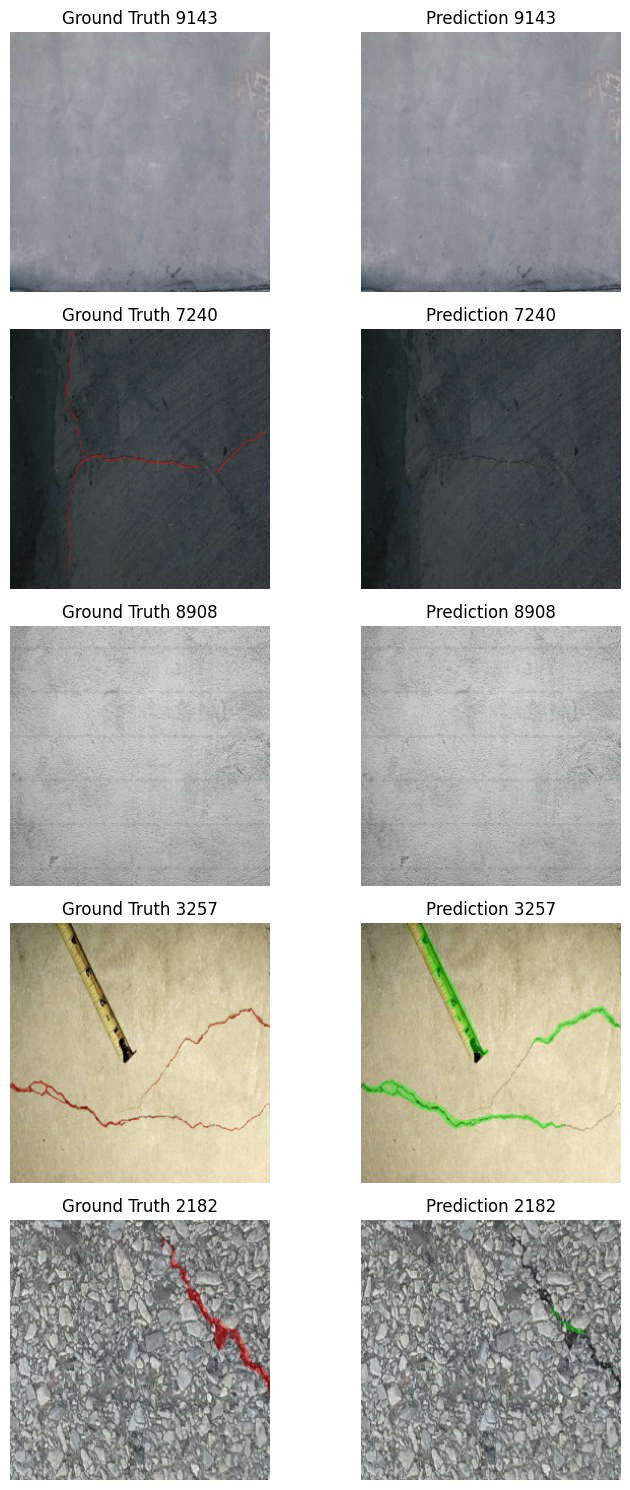

In [ ]:
image_dir = '/content/Conglomerate Concrete Crack Detection/Train/images'
mask_dir = '/content/Conglomerate Concrete Crack Detection/Train/masks'

visualize_predictions(
    model=model,
    image_dir=image_dir,
    mask_dir=mask_dir,
    num_samples=5
)

In [ ]:
from tensorflow.keras.model import load_model

